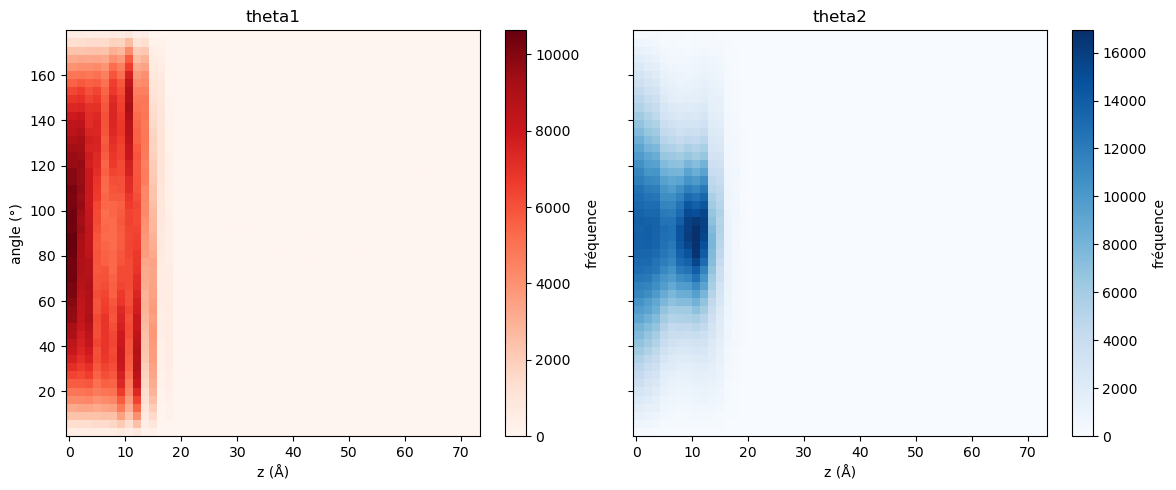

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Chargez le fichier
df = pd.read_csv('freq_angle_scf.dat', sep='\t')

# 2) Remplacez z_center par sa valeur absolue, puis moyenez counts sur z et -z
df['z_center'] = df['z_center'].abs()
df = (
    df
    .groupby(['angle_type','z_center','theta_center'], as_index=False)
    .agg({'count':'mean'})
)

# 3) Tracez ensuite comme avant
angle_types = ['theta1', 'theta2']
cmaps       = ['Reds',   'Blues']
fig, axes   = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, angle_type, cmap in zip(axes, angle_types, cmaps):
    sub = df[df['angle_type'] == angle_type]

    # pivot avec z_center positifs uniquement
    pivot = (
        sub
        .pivot_table(index='theta_center',
                     columns='z_center',
                     values='count',
                     fill_value=0)
        .sort_index().sort_index(axis=1)
    )

    # préparer la grille
    z_edges     = pivot.columns.values
    theta_edges = pivot.index.values
    X, Y = np.meshgrid(z_edges, theta_edges)

    # afficher
    im = ax.pcolormesh(X, Y, pivot.values, cmap=cmap, shading='auto')
    ax.set_xlabel('z (Å)')
    if ax is axes[0]:
        ax.set_ylabel('angle (°)')
    ax.set_title(angle_type)
    fig.colorbar(im, ax=ax, label='fréquence')

plt.tight_layout()
plt.show()


/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_24221/3028884243.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['frequency'] = sub['count'] / sub['count'].sum()
/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_24221/3028884243.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap, 256)
/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_24221/3028884243.py:41: UserWarning: The following kwargs were not used by contour: 'shading'
  im = ax.contourf(X, Y, Z, cmap=cmap, shading='auto')
/var/folders/8h/kqm5zszn2q

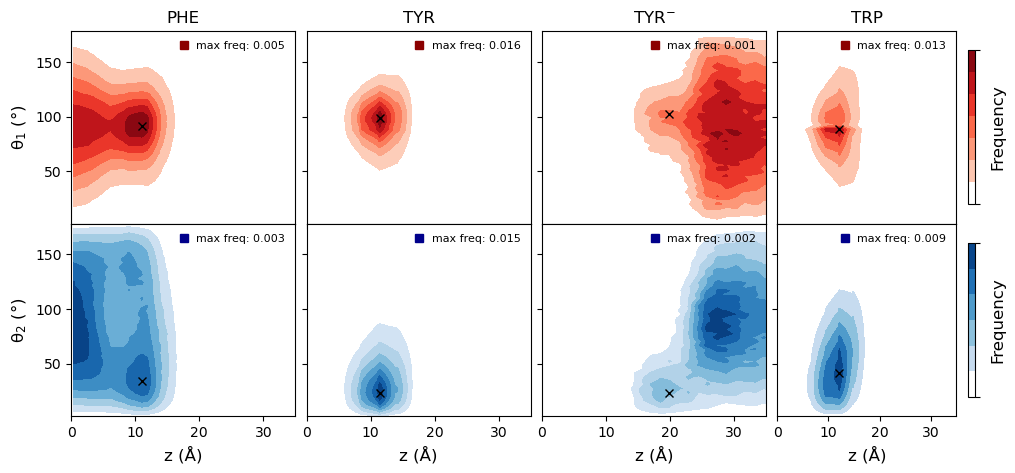

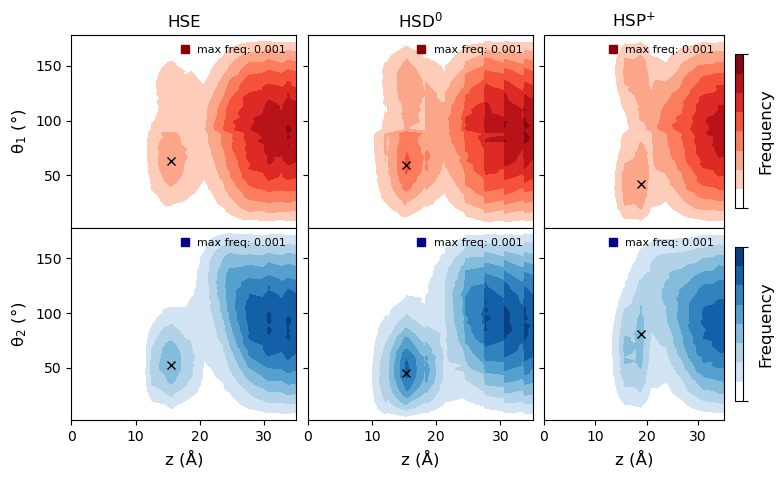

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from matplotlib.colors import ListedColormap

def custom_colormap(base_cmap='Reds', white_ratio=0.1):
    base = plt.cm.get_cmap(base_cmap, 256)
    colors = base(np.linspace(0, 1, 256))
    n_white = int(256 * white_ratio)
    colors[:n_white] = np.array([1, 1, 1, 1])  # blanc RGBA
    return ListedColormap(colors)

def plot_groups(aas, labels, title='aromatics_angles', mark_max=False, individual_cbar=False):
    n = len(aas)
    fig, axes = plt.subplots(2, n,
                             figsize=(n*3, 2*2.5),
                             sharex=True, sharey=True,
                             gridspec_kw={'wspace':0.05, 'hspace':0})

    for j, aa in enumerate(aas):
        df = pd.read_csv(f'freq_angle_{aa}.dat', sep='\t')
        df['z_center'] = df['z_center'].abs()
        df = (df.groupby(['angle_type','z_center','theta_center'], as_index=False)
                ['count'].mean())

        for i, angle in enumerate(['theta1','theta2']):
            ax = axes[i, j]
            sub = df[df['angle_type'] == angle]
            sub['frequency'] = sub['count'] / sub['count'].sum()

            pivot = (sub.pivot(index='theta_center', columns='z_center', values='frequency')
                       .fillna(0)
                       .sort_index().sort_index(axis=1))

            X, Y = np.meshgrid(pivot.columns.values, pivot.index.values)
            #Z = ma.masked_where(pivot.values <= 0.0001, pivot.values)
            Z = pivot.values
            
            cmap = custom_colormap('Reds') if angle == 'theta1' else custom_colormap('Blues')
            im = ax.contourf(X, Y, Z, cmap=cmap, shading='auto')

            ax.set_xlim(0, 35)

            # === 1. AFFICHER FREQUENCE MAXIMALE ===
            freq_max = pivot.values.max()
            color_square = 'darkred' if angle == 'theta1' else 'darkblue'

            ax.plot([], [], color=color_square, marker='s', linestyle='None',
                                            label=f'max freq: {freq_max:.3f}')
            ax.legend(loc='upper right', fontsize=8, frameon=False, handlelength=1.2, handletextpad=0.5)

            # === 2. AJOUTER CROIX ENTRE Z=10 ET 20 ===
            if mark_max:
                sub_z = sub[(sub['z_center'] >= 10) & (sub['z_center'] <= 20)]
                if not sub_z.empty:
                    max_row = sub_z.loc[sub_z['frequency'].idxmax()]
                    ax.plot(max_row['z_center'], max_row['theta_center'],
                            marker='x', markersize=6, color='black', label='max z∈[10,20]')

            if i == 0:
                ax.set_title(labels[aas.index(aa)].upper(), pad=6)
            if j == 0:
                ax.set_ylabel('θ$_1$ (°)' if i==0 else 'θ$_2$ (°)', fontsize=12)
            if i == 1:
                ax.set_xlabel('z (Å)', fontsize=12)
            if individual_cbar:
                cbar = fig.colorbar(im, ax=ax, location='top', orientation='horizontal',
                                    pad=0.01, aspect=20, shrink=0.7)
                ticks = np.linspace(im.get_clim()[0], im.get_clim()[1], 3)
                cbar.set_ticks(ticks)
                cbar.set_ticklabels([f"{t:.3f}" for t in ticks])
                cbar.ax.tick_params(labelsize=8)
            elif j == n-1:
                cbar = fig.colorbar(im, ax=ax, location='right', pad=0.05, shrink=0.8)
                cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
                #cbar.set_ticklabels(['low','high'], fontsize=20)
                cbar.set_ticklabels(['',''], fontsize=10)
                cbar.ax.tick_params(labelsize=12)
                cbar.set_label("Frequency", rotation=90, fontsize=12)

    plt.savefig(f'{title}.png', dpi=1200, bbox_inches='tight')
    return fig

fig1 = plot_groups(['scf', 'scy','scym', 'scw'],
                   labels=['PHE', 'TYR', 'TYR$^{-}$', 'TRP'],
                   title='aromatics_angles',
                   mark_max=False,
                   individual_cbar=False)
fig2 = plot_groups(['sche','schd','schp'],
                   labels=['HSE', 'HSD$^0$', 'HSP$^{+}$'],
                   title='histidine_angles',
                   mark_max=False)



/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_24221/1410357455.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['frequency'] = (sub['count'] / sub['count'].sum())*multi
/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_24221/1410357455.py:49: UserWarning: The following kwargs were not used by contour: 'shading'
  im = ax.contourf(X, Y, pivot.values, cmap=cmap, shading='auto',
/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_24221/1410357455.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

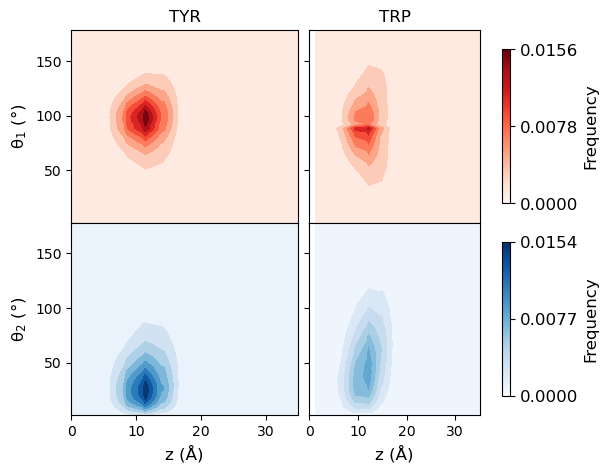

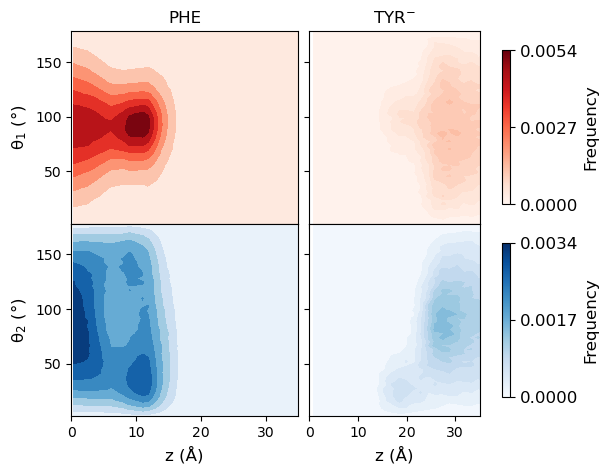

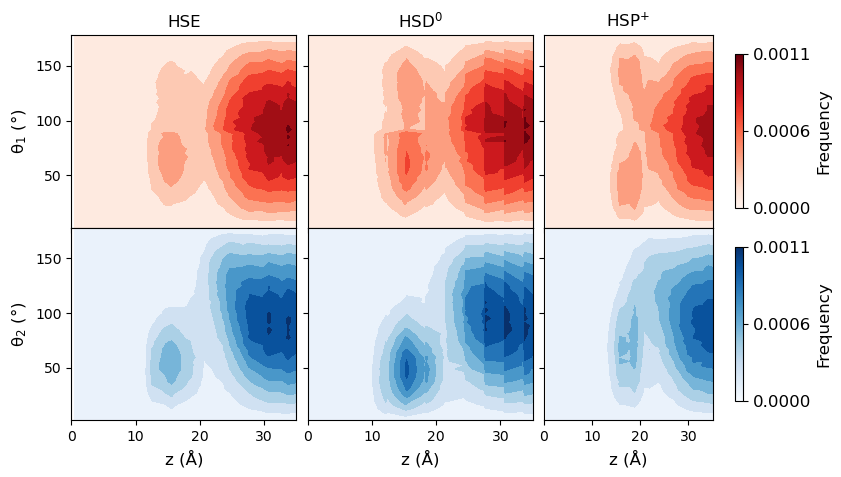

In [102]:
############### sum frequency = 1 ###########
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



def plot_groups(aas, labels, title='aromatics_angles'):
    n = len(aas)
    vmax_dict = {'theta1': 0, 'theta2': 0}
    # chaque case aura ~4×4 pouces
    fig, axes = plt.subplots(2, n,
                             figsize=(n*3, 2*2.5),
                             sharex=True, sharey=True,
                             gridspec_kw={'wspace':0.05, 'hspace':0})
    for aa in aas:
        df = pd.read_csv(f'freq_angle_{aa}.dat', sep='\t')
        df['z_center'] = df['z_center'].abs()
        for angle in ['theta1', 'theta2']:
            sub = df[df['angle_type'] == angle]
            multi = 1 if aa=='scym' else 1
            freq = sub['count'] / sub['count'].sum()*multi  # ou autre normalisation
            max_freq = freq.max()
            vmax_dict[angle] = max(vmax_dict[angle], max_freq)

    for j, aa in enumerate(aas):
        df = pd.read_csv(f'freq_angle_{aa}.dat', sep='\t')
        df['z_center'] = df['z_center'].abs()
        df = (df.groupby(['angle_type','z_center','theta_center'], as_index=False)
                ['count'].mean())
        
        for i, angle in enumerate(['theta1','theta2']):
            ax = axes[i, j]
            sub = df[df['angle_type']==angle]
            multi = 1 if aa=='scym' else 1
            sub['frequency'] = (sub['count'] / sub['count'].sum())*multi
            #pivot = (sub.pivot(index='theta_center', columns='z_center',values='count')
            pivot = (sub.pivot(index='theta_center', columns='z_center', values='frequency')
                       .fillna(0)
                       .sort_index().sort_index(axis=1))
            vmax = vmax_dict[angle]
            #vmax = 1
            X, Y = np.meshgrid(pivot.columns.values,
                               pivot.index.values)
            cmap = 'Reds' if angle=='theta1' else 'Blues'
            #im = ax.pcolormesh(X, Y, pivot.values, cmap=cmap, shading='auto', vmin=0, vmax=1)
            im = ax.contourf(X, Y, pivot.values, cmap=cmap, shading='auto',
                             vmax=vmax)
                             # vmin=0, vmax=1)


            ax.set_xlim(0, 35)
            #ax.set_aspect('equal')

            if i == 0:
                ax.set_title(labels[aas.index(aa)].upper(), pad=6)
            if j == 0:
                if i==0:
                    ax.set_ylabel('θ$_1$ (°)', fontsize=12)
                else:
                    ax.set_ylabel('θ$_2$ (°)', fontsize=12)
            if i == 1:
                ax.set_xlabel('z (Å)', fontsize=12)

            if j == n-1:
                norm = Normalize(vmin=0, vmax=vmax_dict[angle])
                sm = ScalarMappable(norm=norm, cmap=cmap)
                cbar = fig.colorbar(sm, ax=ax, location='right', pad=0.1, shrink=0.8)
                #for a colobar 'low' and 'high'
                #cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
                #cbar.set_ticklabels(['low','high'], fontsize=20)
                #for a colorbar with frequency
                vmin = 0
                ticks = np.linspace(vmin, vmax, 3)
                cbar.set_label("Frequency", rotation=90, fontsize=12)
                cbar.set_ticks(ticks)
                cbar.set_ticklabels([f"{t:.4f}" for t in ticks])
                cbar.ax.tick_params(labelsize=12)
    plt.savefig(f'{title}.png', dpi=1200, bbox_inches='tight')
    # marges externes
    #fig.subplots_adjust(left=0.05, right=0.95,
                        #top=0.92, bottom=0.07)
    return fig

# Exemple d’appel
fig1 = plot_groups(['scy','scw'],
                   labels=['TYR', 'TRP'], title='YW_sum1')
fig1 = plot_groups(['scf','scym'],
                   labels=['PHE', 'TYR$^{-}$'], title='FY-_sum1')
fig2 = plot_groups(['sche','schd','schp'],
                   labels=['HSE', 'HSD$^0$', 'HSP$^{+}$'], title='HIS_sum1')


/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_24221/487812189.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['frequency'] = (sub['count'] / sub['count'].max())*multi
/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_24221/487812189.py:49: UserWarning: The following kwargs were not used by contour: 'shading'
  im = ax.contourf(X, Y, pivot.values, cmap=cmap, shading='auto',
/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_24221/487812189.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

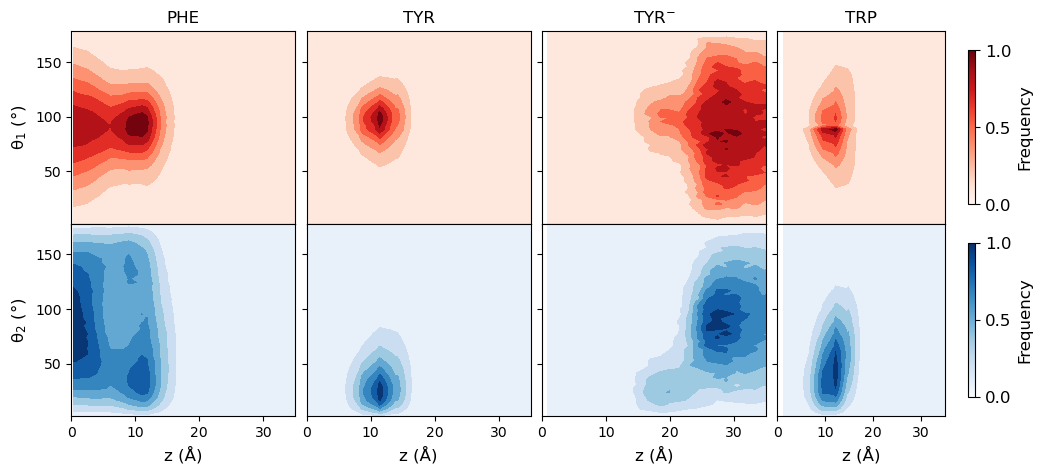

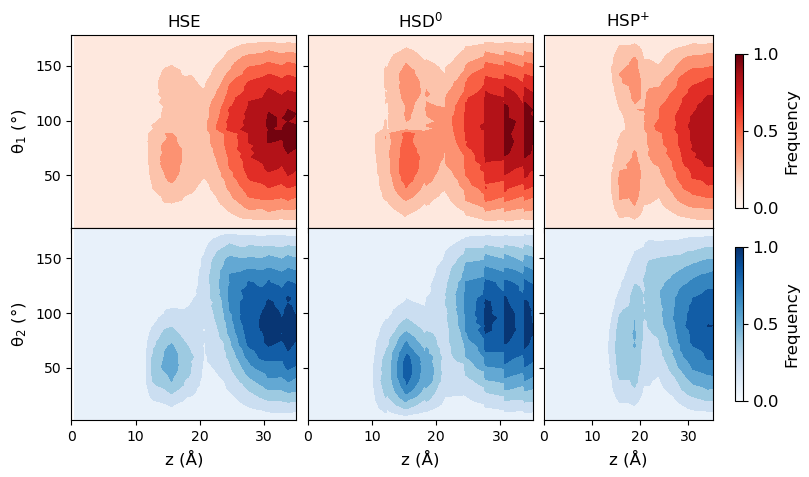

In [104]:
########## max frequency =1 #########
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



def plot_groups(aas, labels, title='aromatics_angles'):
    n = len(aas)
    vmax_dict = {'theta1': 0, 'theta2': 0}
    # chaque case aura ~4×4 pouces
    fig, axes = plt.subplots(2, n,
                             figsize=(n*3, 2*2.5),
                             sharex=True, sharey=True,
                             gridspec_kw={'wspace':0.05, 'hspace':0})
    for aa in aas:
        df = pd.read_csv(f'freq_angle_{aa}.dat', sep='\t')
        df['z_center'] = df['z_center'].abs()
        for angle in ['theta1', 'theta2']:
            sub = df[df['angle_type'] == angle]
            multi = 1 if aa=='scym' else 1
            freq = sub['count'] / sub['count'].max()*multi  # ou autre normalisation
            max_freq = freq.max()
            vmax_dict[angle] = max(vmax_dict[angle], max_freq)

    for j, aa in enumerate(aas):
        df = pd.read_csv(f'freq_angle_{aa}.dat', sep='\t')
        df['z_center'] = df['z_center'].abs()
        df = (df.groupby(['angle_type','z_center','theta_center'], as_index=False)
                ['count'].mean())
        
        for i, angle in enumerate(['theta1','theta2']):
            ax = axes[i, j]
            sub = df[df['angle_type']==angle]
            multi = 1 if aa=='scym' else 1
            sub['frequency'] = (sub['count'] / sub['count'].max())*multi
            #pivot = (sub.pivot(index='theta_center', columns='z_center',values='count')
            pivot = (sub.pivot(index='theta_center', columns='z_center', values='frequency')
                       .fillna(0)
                       .sort_index().sort_index(axis=1))
            vmax = vmax_dict[angle]
            #vmax = 1
            X, Y = np.meshgrid(pivot.columns.values,
                               pivot.index.values)
            cmap = 'Reds' if angle=='theta1' else 'Blues'
            #im = ax.pcolormesh(X, Y, pivot.values, cmap=cmap, shading='auto', vmin=0, vmax=1)
            im = ax.contourf(X, Y, pivot.values, cmap=cmap, shading='auto',
                             vmax=vmax)
                             # vmin=0, vmax=1)


            ax.set_xlim(0, 35)
            #ax.set_aspect('equal')

            if i == 0:
                ax.set_title(labels[aas.index(aa)].upper(), pad=6)
            if j == 0:
                if i==0:
                    ax.set_ylabel('θ$_1$ (°)', fontsize=12)
                else:
                    ax.set_ylabel('θ$_2$ (°)', fontsize=12)
            if i == 1:
                ax.set_xlabel('z (Å)', fontsize=12)

            if j == n-1:
                norm = Normalize(vmin=0, vmax=vmax_dict[angle])
                sm = ScalarMappable(norm=norm, cmap=cmap)
                cbar = fig.colorbar(sm, ax=ax, location='right', pad=0.1, shrink=0.8)
                #for a colobar 'low' and 'high'
                #cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
                #cbar.set_ticklabels(['low','high'], fontsize=20)
                #for a colorbar with frequency
                vmin = 0
                ticks = np.linspace(vmin, vmax, 3)
                cbar.set_label("Frequency", rotation=90, fontsize=12)
                cbar.set_ticks(ticks)
                cbar.set_ticklabels([f"{t:.1f}" for t in ticks])
                cbar.ax.tick_params(labelsize=12)
    plt.savefig(f'{title}.png', dpi=1200, bbox_inches='tight')
    # marges externes
    #fig.subplots_adjust(left=0.05, right=0.95,
                        #top=0.92, bottom=0.07)
    return fig

# Exemple d’appel
fig1 = plot_groups(['scf','scy','scym','scw'],
                   labels=['PHE', 'TYR', 'TYR$^{-}$', 'TRP'], title='FYY-W_max1')
fig2 = plot_groups(['sche','schd','schp'],
                   labels=['HSE', 'HSD$^0$', 'HSP$^{+}$'], title='HIS_max1')


In [30]:
aas = ['scf','scy','scym','scw']
aas = ['sche','schd','schp']  # ou ton autre liste
for aa in aas:
    df = pd.read_csv(f'freq_angle_{aa}.dat', sep='\t')
    total = df['count'].sum()
    print(f"{aa}: total count = {total}")

sche: total count = 6240000
schd: total count = 6240000
schp: total count = 6240000


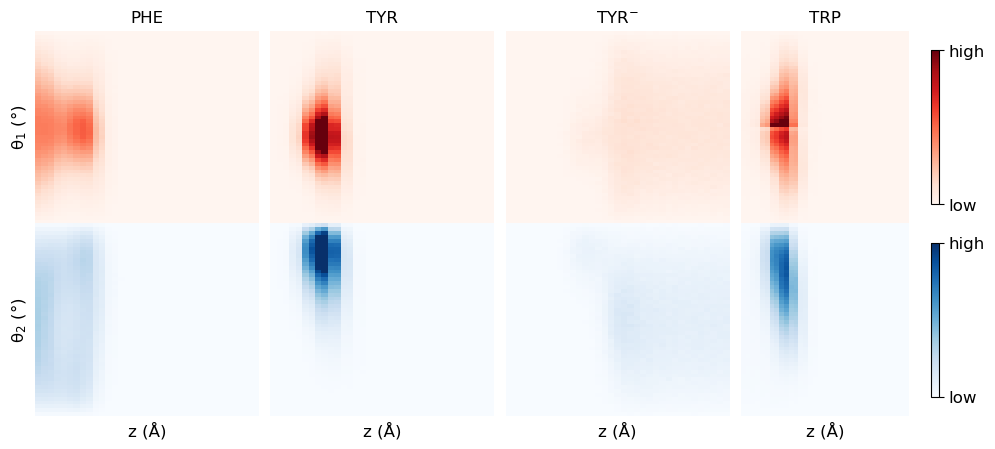

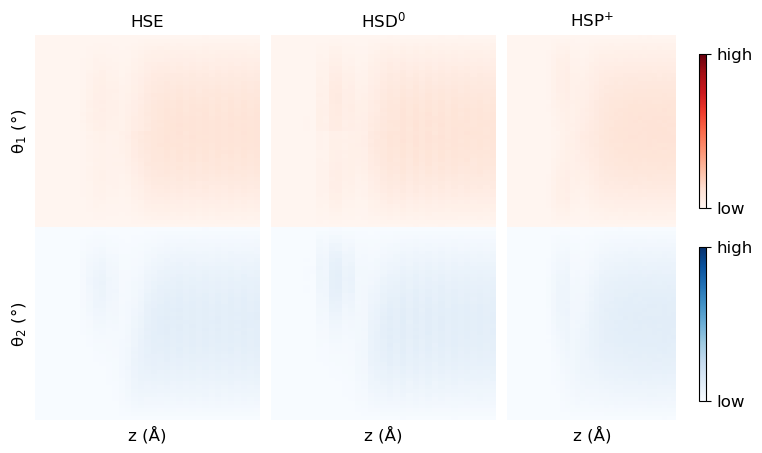

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def plot_groups_sns(aas, labels, title='aromatics_angles'):
    n = len(aas)
    fig, axes = plt.subplots(2, n,
                             figsize=(n*3, 2*2.5),
                             sharex=True, sharey=True,
                             gridspec_kw={'wspace':0.05, 'hspace':0})

    for j, aa in enumerate(aas):
        df = pd.read_csv(f'freq_angle_{aa}.dat', sep='\t')
        df['z_center'] = df['z_center'].abs()
        #df = (df.groupby(['angle_type', 'z_center', 'theta_center'], as_index=False)['count'].mean())
        df = df.copy()
        df['frequency'] = df['count'] / df['count'].sum()
        df = (df.groupby(['angle_type', 'z_center', 'theta_center'], as_index=False)['frequency'].mean())
        for i, angle in enumerate(['theta1', 'theta2']):
            ax = axes[i, j]
            sub = df[df['angle_type'] == angle]
            pivot = (sub.pivot(index='theta_center',
                               columns='z_center',
                               values='frequency')
                       .fillna(0)
                       .sort_index()
                       .sort_index(axis=1))

            cmap = 'Reds' if angle == 'theta1' else 'Blues'
            
            # plot sans colorbar (on la gère séparément)
            sns.heatmap(pivot, ax=ax, cmap=cmap, cbar=False,
                        vmin=0, vmax=0.005,
                        linewidths=0, linecolor='gray', square=False)

            ax.set_xlim(0, 35)
            # Pour l’axe Y (theta)
            yticks = [tick for tick in range(1, 180, 30) if tick in pivot.index]
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks)

            # Pour l’axe X (z)
            xticks = [tick for tick in range(0, 35, 10) if tick in pivot.columns]
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks)
            if i == 0:
                ax.set_title(labels[aas.index(aa)].upper(), pad=6)
            if j == 0:
                if i == 0:
                    ax.set_ylabel('θ$_1$ (°)', fontsize=12)
                else:
                    ax.set_ylabel('θ$_2$ (°)', fontsize=12)
            else:
                ax.set_ylabel('')
            if i == 1:
                ax.set_xlabel('z (Å)', fontsize=12)
            else:
                ax.set_xlabel('')

            # Ajoute colorbar uniquement à la dernière colonne
            if j == n - 1:
                norm = Normalize(vmin=0, vmax=0.005)
                sm = ScalarMappable(norm=norm, cmap=cmap)
                cbar = fig.colorbar(sm, ax=ax, location='right', pad=0.1, shrink=0.8)
                cbar.set_ticks([0, 0.005])
                cbar.set_ticklabels(['low', 'high'])
                cbar.ax.tick_params(labelsize=12)

    plt.savefig(f'{title}.png', dpi=1200, bbox_inches='tight')
    return fig

fig1 = plot_groups_sns(['scf','scy','scym','scw'],
                       labels=['PHE', 'TYR', 'TYR$^{-}$', 'TRP'])

fig2 = plot_groups_sns(['sche','schd','schp'],
                       labels=['HSE', 'HSD$^0$', 'HSP$^{+}$'],
                       title='histidine_angles')